# Natural Language Processing
#### Author Name: Kishore Sudhir

Date: 02/10/2023

Version: 1.0

Environment: Python 3 and Jupyter notebook

Libraries used:
* nltk
* pandas
* matplotlib
* seaborn
* numpy
* sklearn
* itertools
* gensim

## Introduction
This file investigates job advertisement text analysis, covering Tasks 2 and 3. Task 2 focuses on creating varied feature representations for job advertisement descriptions. This involves constructing Count vectors based on the Task 1 vocabulary and utilising popular language model Word2Vec or any other pretrained models) to create both unweighted and TF-IDF weighted vector representations. 

The third and most important task in the project is the categorisation of job advertisements. Machine learning model logistic regression is used to answer two important issues. First, the performance of several language models and feature representations is evaluated. Second, the influence of including extra information, such as job titles, in the categorisation process is studied. The goal of navigating these problems is to discover optimum techniques for job advertisement categorisation and to emphasise the importance of feature selection in text analysis.




## Importing libraries 

In [1]:
# Code to import libraries as you need in this assessment, e.g.,
from nltk.probability import *
from itertools import chain
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from itertools import islice
import gensim.downloader as api
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.model_selection import KFold


## Task 2. Generating Feature Representations for Job Advertisement Descriptions

Let's start with reading the stored files form task 1

In [2]:
with open("generated_features/descriptions.txt") as f:
    # tk_descriptions = f.read().splitlines()
    tk_descriptions = [line.strip() for line in f.read().splitlines()] # to remove \n in the last word


with open("generated_features/industry.txt") as f:
    industry = f.read().splitlines()

with open("generated_features/web_index.txt") as f:
    web_index = f.read().splitlines()


`tk_descriptions` stores  processed description data

In [3]:
tk_descriptions[0]

'accountant partqualified south east london manufacturing requirement accountant permanent modern offices south east london credit control purchase ledger daily collection debts phone letter email handling ledger accounts handling accounts negotiating payment terms cash reconciliation accounts adhoc administration duties person ideal previous credit control capacity possess exceptional part fully qualified accountant considered'

Read the stored vocabulary into `vocab`and `vocab_index`

`vocab` copies only words   
`vocab_index` takes the word_string:word_integer_index format 

In [4]:
# reading our vocab

vocab = []
vocab_index = {}

with open("generated_features/vocab.txt") as f:
    for line in f:
        # Split the line by ':' to separate word and index
        parts = line.strip().split(':')
        if len(parts) == 2:
            word, index = parts[0], int(parts[1])
            vocab.append(word)
            vocab_index[word] = index

# Now, vocab contains the list of words, and vocab_index contains the word-to-index mapping
print(vocab[0:5])
vocabcopy = vocab
# print(vocab_index)

['aap', 'aaron', 'aat', 'abb', 'abenefit']


In [5]:

sample_size = 10

sample_dict = dict(islice(vocab_index.items(), sample_size))

# Print the first sample_size key-value pairs
for key, value in sample_dict.items():
    print(f'{key}: {value}') # first 10 in vocab_index

# to see full size, uncomment below
# print(vocab_index)

aap: 0
aaron: 1
aat: 2
abb: 3
abenefit: 4
aberdeen: 5
abi: 6
abilities: 7
abreast: 8
abroad: 9


Few useful functions are defined for the repeated operation

In [6]:
def gen_words(tk_features):
    """Function to flatten a list of tokenized features into a list of words.

    """
    return list(chain.from_iterable(tk_descriptions))

In [7]:
def split_token(tk_features):
    """
    Function to split tokenized features, represented as strings with words separated by spaces, into lists of words.
    """
    return [feat.split(" ") for feat in tk_features]

In [8]:
def join_token(tk_features):
    """
    Function to join tokenized features, represented as lists of words, into strings with words separated by spaces.
    """
    return [' '.join(feat) for feat in tk_features]
    

Verifying whether the lengths are matching is of utmost importance.

In [9]:
len(tk_descriptions),len(industry),len(web_index)

(776, 776, 776)

phew!  
They are fine :)

In [10]:
def stats_print(tk_descriptions):
    """
    Function to print few stats of the given tokenized feature.

    NOTE:
    This function is taken from week 7 lab exercise, with very little changes
    """
    words = gen_words(tk_descriptions)
    vocab = set(words)
    lexical_diversity = len(vocab)/len(words)
    print("Vocabulary size: ",len(vocab))
    print("Total number of tokens: ", len(words))
    print("Lexical diversity: ", lexical_diversity)
    print("Total number of description:", len(tk_descriptions))
    lens = [len(article) for article in tk_descriptions]
    print("Average description length:", np.mean(lens))
    print("Maximun description length:", np.max(lens))
    print("Minimun description length:", np.min(lens))
    print("Standard deviation of description length:", np.std(lens))

In [11]:
ind = 7
tk_descriptions = split_token(tk_descriptions) # tokenizing based on words, " " based

In [12]:
print(tk_descriptions[ind])

['recruit', 'experienced', 'purchase', 'ledger', 'clerk', 'covering', 'maternity', 'february', 'mid', 'year', 'ideal', 'immediately', 'duties', 'responsibilities', 'limited', 'ledger', 'input', 'cheques', 'bacs', 'received', 'sage', 'accurately', 'reconcile', 'actual', 'receipts', 'prepare', 'banking', 'book', 'responsible', 'ensure', 'credit', 'control', 'professional', 'timely', 'manner', 'send', 'statements', 'monthly', 'basis', 'managing', 'aged', 'debtors', 'report', 'purchase', 'ledger', 'prepare', 'payment', 'run', 'ensuring', 'invoices', 'due', 'processed', 'log', 'payments', 'sage', 'cheques', 'bacs', 'deal', 'account', 'payable', 'queries', 'managing', 'aged', 'creditors', 'report', 'requirements', 'years', 'systems', 'invoicing', 'understanding', 'computer', 'literate', 'office', 'outlook', 'word', 'excel', 'sage', 'preferred', 'minimum', 'sage', 'tight', 'deadlines', 'errors', 'numeracy', 'organised', 'efficient', 'attention', 'detail', 'totaljobs']


In [13]:
stats_print(tk_descriptions)

Vocabulary size:  5059
Total number of tokens:  78822
Lexical diversity:  0.06418258861739108
Total number of description: 776
Average description length: 101.57474226804123
Maximun description length: 392
Minimun description length: 1
Standard deviation of description length: 58.88652884635628


In [14]:
# convert to int
industry = [int(i) for i in industry]
sum(industry)

1095

In [15]:
industry[ind]

0

### Task 2.1 Bag-of-words model

Here, count based vector is created using `CountVectorizer` from `sklearn.feature_extraction.text`  


For bag of words model, as mentioned in requiremnts vocab generated in task 1 is used.

In [16]:
# Bag of Words. 

joined_descp = join_token(tk_descriptions)

countVectorizer = CountVectorizer(analyzer = "word",vocabulary = vocab) # count based vector

In [17]:
count_features = countVectorizer.fit_transform(joined_descp)
count_features.shape

(776, 5058)

shape looks good :)

In shape(i,j), i is same as the data - `tk_descriptions` and `industry`

In [18]:
count_vector_array = count_features.toarray()
count_vector_array[0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

A validator function, built by referring to week 8 lab materials, can be employed to verify the correctness of `count_features`.

In [19]:
def validator(data_features, vocab, a_ind, article_ids,tk_descriptions):
    """
    Function to validate tokenized featuer and it's vector representation

    NOTE:
    This function is inspired from week 8 lab material
    """
    print("Web Index:", web_index[a_ind])
    print("--------------------------------------------")
    print("Article tokens:",tk_descriptions[a_ind]) 
    print("--------------------------------------------\n")
    print("Vector representation:\n") # printing the vector representation as format 'word:value' (
                                      # the value is an integer for count vector and a float value for tfidf

    for word, value in zip(vocab, data_features.toarray()[a_ind]): 
        if value > 0:
            print(word+":"+str(value), end =' ')

In [20]:
validator(count_features,vocab,ind, web_index,tk_descriptions)

Web Index: 68684698
--------------------------------------------
Article tokens: ['recruit', 'experienced', 'purchase', 'ledger', 'clerk', 'covering', 'maternity', 'february', 'mid', 'year', 'ideal', 'immediately', 'duties', 'responsibilities', 'limited', 'ledger', 'input', 'cheques', 'bacs', 'received', 'sage', 'accurately', 'reconcile', 'actual', 'receipts', 'prepare', 'banking', 'book', 'responsible', 'ensure', 'credit', 'control', 'professional', 'timely', 'manner', 'send', 'statements', 'monthly', 'basis', 'managing', 'aged', 'debtors', 'report', 'purchase', 'ledger', 'prepare', 'payment', 'run', 'ensuring', 'invoices', 'due', 'processed', 'log', 'payments', 'sage', 'cheques', 'bacs', 'deal', 'account', 'payable', 'queries', 'managing', 'aged', 'creditors', 'report', 'requirements', 'years', 'systems', 'invoicing', 'understanding', 'computer', 'literate', 'office', 'outlook', 'word', 'excel', 'sage', 'preferred', 'minimum', 'sage', 'tight', 'deadlines', 'errors', 'numeracy', 'orga

The Web Index, Article tokens, and Vector representation align with each other.

In [21]:
# save in count_vectors
count_vectors = []

# Iterate through each count vector and its corresponding web index
for web_index, count_vector in zip(web_index, count_features):
    # Convert the count vector to a dictionary of word frequencies
    word_freq_dict = {}
    non_zero_indices = count_vector.indices
    non_zero_counts = count_vector.data

    for index, count in zip(non_zero_indices, non_zero_counts):
        word_freq_dict[index] = count

    # Convert the word frequency dictionary to a string
    vector_str = ','.join(f'{index}:{count}' for index, count in word_freq_dict.items())

    # Create the final line for the sparse representation
    counts = f'#{web_index},{vector_str}'

    # Append the sparse line to the list of sparse vectors
    count_vectors.append(counts)

# count_vectors

In [22]:
count_vectors[ind]

'#68684698,27:1,41:1,64:1,150:2,361:1,421:2,429:1,442:1,522:1,766:2,814:1,943:1,1038:1,1105:1,1124:1,1125:1,1181:1,1182:1,1193:1,1279:1,1431:1,1439:1,1491:1,1586:1,1588:1,1621:1,1672:1,1715:1,1784:1,2243:1,2260:1,2353:1,2460:1,2461:1,2595:3,2641:1,2663:1,2687:1,2751:2,2754:1,2788:1,2879:1,2911:1,2949:1,3073:1,3119:1,3198:1,3223:1,3312:1,3315:1,3316:1,3499:1,3507:2,3580:1,3596:1,3680:2,3712:1,3770:1,3772:1,3788:1,3797:1,3887:2,3904:1,3942:1,3944:1,4039:1,4051:4,4151:1,4377:1,4547:1,4652:1,4658:1,4683:1,4776:1,5011:1,5046:1,5049:1'

Let's check if index and word are matching

In [23]:
# validation
vector_parts = count_vectors[ind].split(',')
# Extract the word:count pairs starting from the second element, # not
word_count = vector_parts[1:] # ignoring `#digits like #68684698 for now

# Initialize an index-value dictionary from the word:count pairs
word_count_dict = {}
for pair in word_count:
    index, count = pair.split(':')
    word_count_dict[int(index)] = int(count)

# Print word:count pairs for non-zero counts
for index, value in word_count_dict.items():
    if value > 0:
        word = vocab[index]
        print(f"{word}:{value}", end=' ')

account:1 accurately:1 actual:1 aged:2 attention:1 bacs:2 banking:1 basis:1 book:1 cheques:2 clerk:1 computer:1 control:1 covering:1 credit:1 creditors:1 deadlines:1 deal:1 debtors:1 detail:1 due:1 duties:1 efficient:1 ensure:1 ensuring:1 errors:1 excel:1 experienced:1 february:1 ideal:1 immediately:1 input:1 invoices:1 invoicing:1 ledger:3 limited:1 literate:1 log:1 managing:2 manner:1 maternity:1 mid:1 minimum:1 monthly:1 numeracy:1 office:1 organised:1 outlook:1 payable:1 payment:1 payments:1 preferred:1 prepare:2 processed:1 professional:1 purchase:2 queries:1 receipts:1 received:1 reconcile:1 recruit:1 report:2 requirements:1 responsibilities:1 responsible:1 run:1 sage:4 send:1 statements:1 systems:1 tight:1 timely:1 totaljobs:1 understanding:1 word:1 year:1 years:1 

_____________________________________________

account:1 accurately:1 actual:1 aged:2 attention:1 bacs:2 banking:1 basis:1 book:1 cheques:2 clerk:1 computer:1 control:1 covering:1 credit:1 creditors:1 deadlines:1 deal:1 debtors:1 detail:1 due:1 duties:1 efficient:1 ensure:1 ensuring:1 errors:1 excel:1 experienced:1 february:1 ideal:1 immediately:1 input:1 invoices:1 invoicing:1 ledger:3 limited:1 literate:1 log:1 managing:2 manner:1 maternity:1 mid:1 minimum:1 monthly:1 numeracy:1 office:1 organised:1 outlook:1 payable:1 payment:1 payments:1 preferred:1 prepare:2 processed:1 professional:1 purchase:2 queries:1 receipts:1 received:1 reconcile:1 recruit:1 report:2 requirements:1 responsibilities:1 responsible:1 run:1 sage:4 send:1 statements:1 systems:1 tight:1 timely:1 totaljobs:1 understanding:1 word:1 year:1 years:1

_____________________________________________

Values from before and after are matching

### Task 2.2 Models based on word embeddings

Goal is to create both unweighted and TF-IDF weighted vector representations

As there is no restriction (or requirement) of using the vocab file form task1, few more processing (Lemmatization and bigrams) is carried out to improve vocabulary


<p style="font-size:12px;">Note: lemmatizer and bigrams will not be performed for title.</p>

In [24]:
# setting words for this tasks
words_descp = gen_words(tk_descriptions)#list(chain.from_iterable(tk_descriptions))
vocab_descp = set(words_descp)
words_descp[0:5]

['accountant', 'partqualified', 'south', 'east', 'london']

In [25]:
# lemmatizer

lemmatizer = WordNetLemmatizer()

processed = ['{0} -> {1}'.format(w, lemmatizer.lemmatize(w)) for w in vocab_descp if w!=lemmatizer.lemmatize(w)] # week 7 lab
print(len(processed))


843


843 words!  

That's a lot

In [26]:
processed[:25]

['universities -> university',
 'offices -> office',
 'examinations -> examination',
 'analysers -> analyser',
 'challenges -> challenge',
 'pumps -> pump',
 'technologies -> technology',
 'deals -> deal',
 'supports -> support',
 'electricians -> electrician',
 'discussions -> discussion',
 'associates -> associate',
 'connections -> connection',
 'glasses -> glass',
 'margins -> margin',
 'disclaimers -> disclaimer',
 'entries -> entry',
 'appraisals -> appraisal',
 'supermarkets -> supermarket',
 'boxes -> box',
 'employs -> employ',
 'creditors -> creditor',
 'categories -> category',
 'maths -> math',
 'promises -> promise']

In [27]:
# lemmatizer those words

tk_descriptions = [[lemmatizer.lemmatize(w) for w in descp] for descp in tk_descriptions]

In [28]:
stats_print(tk_descriptions)

Vocabulary size:  4437
Total number of tokens:  78822
Lexical diversity:  0.056291390728476824
Total number of description: 776
Average description length: 101.57474226804123
Maximun description length: 392
Minimun description length: 1
Standard deviation of description length: 58.88652884635628


In [29]:
# biagrams

bigrams = ngrams(words_descp,n=2)
fdbigram = FreqDist(bigrams)
fdbigram

FreqDist({('nbsp', 'nbsp'): 148, ('employment', 'agency'): 102, ('track', 'record'): 75, ('nursing', 'home'): 66, ('acting', 'employment'): 55, ('health', 'safety'): 54, ('care', 'home'): 49, ('days', 'holiday'): 43, ('day', 'day'): 42, ('equal', 'opportunities'): 42, ...})

In [30]:
# remove nbsp

words = [word for word in words_descp if word != 'nbsp']
bigrams = ngrams(words,n=2)

fdbigram = FreqDist(bigrams)
fdbigram

FreqDist({('employment', 'agency'): 102, ('track', 'record'): 75, ('nursing', 'home'): 66, ('acting', 'employment'): 55, ('health', 'safety'): 54, ('care', 'home'): 49, ('days', 'holiday'): 43, ('day', 'day'): 42, ('equal', 'opportunities'): 42, ('proven', 'track'): 41, ...})

In [31]:
bigrams = fdbigram.most_common(25) # top 25 bigrams
bigrams

[(('employment', 'agency'), 102),
 (('track', 'record'), 75),
 (('nursing', 'home'), 66),
 (('acting', 'employment'), 55),
 (('health', 'safety'), 54),
 (('care', 'home'), 49),
 (('days', 'holiday'), 43),
 (('day', 'day'), 42),
 (('equal', 'opportunities'), 42),
 (('proven', 'track'), 41),
 (('hours', 'week'), 41),
 (('relation', 'vacancy'), 39),
 (('design', 'engineer'), 38),
 (('face', 'face'), 37),
 (('pension', 'scheme'), 37),
 (('registered', 'nurse'), 36),
 (('agency', 'relation'), 34),
 (('wide', 'range'), 34),
 (('attention', 'detail'), 34),
 (('career', 'progression'), 34),
 (('key', 'responsibilities'), 34),
 (('minimum', 'years'), 34),
 (('mental', 'health'), 34),
 (('nursing', 'care'), 33),
 (('driving', 'licence'), 32)]

In [32]:
rep_patterns = [" ".join(bg[0]) for bg in bigrams]

There are lot of words that are meaning full, but some are not. Let's remove them

In [33]:
filtered = ['day day', 'face face'] # not making sense, migth be be face to face (not 100% sure) as we removed stop words, it better to remove these
rep_patterns = [bg for bg in rep_patterns if bg not in filtered]
rep_patterns

['employment agency',
 'track record',
 'nursing home',
 'acting employment',
 'health safety',
 'care home',
 'days holiday',
 'equal opportunities',
 'proven track',
 'hours week',
 'relation vacancy',
 'design engineer',
 'pension scheme',
 'registered nurse',
 'agency relation',
 'wide range',
 'attention detail',
 'career progression',
 'key responsibilities',
 'minimum years',
 'mental health',
 'nursing care',
 'driving licence']

Now, need to combine bigram words. `"_"` is used to combined two words

In [34]:
replacements = [bg.replace(" ","_") for bg in rep_patterns] # convert the format of bigram into word1_word2
replacements # all above snippents are week 8

['employment_agency',
 'track_record',
 'nursing_home',
 'acting_employment',
 'health_safety',
 'care_home',
 'days_holiday',
 'equal_opportunities',
 'proven_track',
 'hours_week',
 'relation_vacancy',
 'design_engineer',
 'pension_scheme',
 'registered_nurse',
 'agency_relation',
 'wide_range',
 'attention_detail',
 'career_progression',
 'key_responsibilities',
 'minimum_years',
 'mental_health',
 'nursing_care',
 'driving_licence']

In [35]:
tk_descriptions = join_token(tk_descriptions) # construct the review string, list to stings or sentance

for i in range(0, len(tk_descriptions)): 
    for j in  range(0,len(rep_patterns)):
        # Replace with patterns
        # code similar to lab material
        tk_descriptions[i] = re.sub(rep_patterns[j], replacements[j], tk_descriptions[i]) # replace with bigram representation 

tk_descriptions = [descp.split(" ") for descp in tk_descriptions] # convert back to tokenised review

In [36]:
stats_print(tk_descriptions)

Vocabulary size:  4467
Total number of tokens:  77936
Lexical diversity:  0.05731625949497023
Total number of description: 776
Average description length: 100.43298969072166
Maximun description length: 389
Minimun description length: 1
Standard deviation of description length: 58.484627853697255


In [37]:
# words and vocab for the upcoming model - Biagrams and lemnatiser processed

words_descp_v2 = gen_words(tk_descriptions)#list(chain.from_iterable(tk_descriptions)) 
vocab_descp_v2 = sorted(list(set(words_descp_v2)))[1:] #  [1:] removes""

len(vocab_descp_v2)


4466

Finally before actually implementing, pre trained language model. Let's store the data in data frame. 

<p style="font-size:12px;">Note: 
This step is optional. Creating a dataframe is solely for a quick review to ensure that values are correctly store. In this case, only variables are used directly. Nevertheless, storing them as a dataframe provides a future opportunity for easy export.y</p>

In [38]:
# creating a dataframe

data_dict = {'WebIndex':web_index,'Target':industry}
df = pd.DataFrame(data_dict)

In [39]:
map_industry = {
    0: 'Accounting_Finance',
    1: 'Engineering',
    2: 'Healthcare_Nursing',
    3: 'Sales'
}
df['Industry'] = df['Target'].map(map_industry)
df.head()

,WebIndex,Target,Industry
0,71185283,0,Accounting_Finance
1,71185283,0,Accounting_Finance
2,71185283,2,Healthcare_Nursing
3,71185283,0,Accounting_Finance
4,71185283,2,Healthcare_Nursing


In [40]:
df['tk_text'] = tk_descriptions

In [41]:
df.sample(5)

,WebIndex,Target,Industry,tk_text
283,71185283,1,Engineering,"[people, surrounding, postcode, area, visit, c..."
691,71185283,2,Healthcare_Nursing,"[adult, qualified, social, worker, gloucesters..."
426,71185283,2,Healthcare_Nursing,"[nh, organisation, wale, requirement, estate, ..."
84,71185283,0,Accounting_Finance,"[great, specialist, risk, large, financial, ac..."
275,71185283,1,Engineering,"[purpose, design, configuration, testing, virt..."


##### Models based on word embeddings

Now we move to main task of this part that is to build un weighted and weighted models

In [42]:
def docvecs(embeddings, docs):
    """
    Function to compute document vectors based on word embeddings for given documents.

    NOTE: 
    This function is inspired from week 9 contents
    """
    vecs = np.zeros((len(docs), embeddings.vector_size))
    for i, doc in enumerate(docs):
        valid_keys = [term for term in doc if term in embeddings.key_to_index]
        # print([embeddings[term] for term in valid_keys])
        try:
            docvec = np.vstack([embeddings[term] for term in valid_keys])
        except:
            pass
        docvec = np.sum(docvec, axis=0) # pooling
        vecs[i,:] = docvec
    return vecs

In [43]:
# !pip install gensim

Word2Vec has been chosen, and the pre-trained language model `glove-wiki-gigaword-100` is being utilized.

In [44]:
# word2vec

# word2vec-google-news-300 is large file, so could consume some time. To use it uncoment it

# preTrainedModel = api.load('word2vec-google-news-300')

# used smaller file instead
preTrainedModel = api.load('glove-wiki-gigaword-100') # takes little bit of time

# even smaller file, take the least time compared to other two. To use it uncoment it
# preTrainedModel = api.load('glove-wiki-gigaword-50')

In [45]:
unweighted_descp= docvecs(preTrainedModel,tk_descriptions) #unweighted_descp

In [46]:
np.isnan(unweighted_descp).sum() # checking for  null

0

In [47]:
unweighted_descp.shape

(776, 100)

shape is aligning with `tk_descriptions` and `industry`

We will use `plotTSNE` function from week 9 to plot a 2D t-SNE visualization (scatter plot) which will show the distributions.

In [48]:
def plotTSNE(labels,features):
    """
    Function to plot a 2D t-SNE visualization (scatter plot) of document embeddings with labeled data points.
    NOTE: 
    This function is refered from week 9 contents
    """
    categories = sorted(labels.unique()) # store unique and alphabetical categorey values
    # Sampling a subset of our dataset because t-SNE is computationally expensive
    SAMPLE_SIZE = int(len(features) * 0.3)
    np.random.seed(3)
    indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
    projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
    colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']


    # plotting
    for i in range(0,len(categories)):
        points = projected_features[(labels[indices] == categories[i])]
        plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[i], label=categories[i])
    plt.title("Feature vector for each token, projected on 2 dimensions.",
              fontdict=dict(fontsize=15))
    plt.legend()
    plt.show()

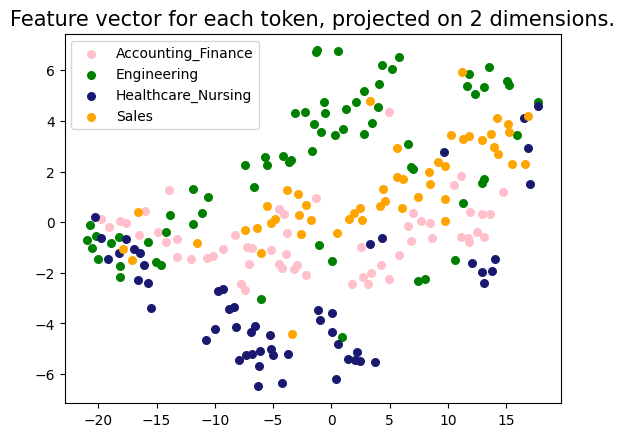

In [49]:
try:
    features = unweighted_descp.to_numpy() # convert the document vector dataframe to a numpy array
except:
    # used `docvec` so already is a numpy array
    features = unweighted_descp
plotTSNE(df['Industry'],features) # plot the tSNE to have a look

Hmm 🤔. There is some overlap, which could potentially impact the model's performance. However, it doesn't appear worse since we can observe that most similar patterns tend to follow certain trends or are distinct from other groups.

Anyways, we can move on to weighted vector representation based on TF-IDF

In [50]:
# weighted
tfidf_vectorizer = TfidfVectorizer(analyzer = "word")

joined_descp = [' '.join(descp) for descp in tk_descriptions]
tfidf_matrix = tfidf_vectorizer.fit_transform(joined_descp)


In [51]:
tfidf_matrix.shape

(776, 4443)

Again, shape is good

In [52]:
vocabulary = tfidf_vectorizer.get_feature_names_out()

In [53]:
len(vocabulary)

4443

Slightly modified validator function to validate

In [54]:
def validator_v2(data_features, vocab, a_ind,tokenised_articles):
    """
    Function to validate tokenized featuer and it's vector representation.
    

    NOTE:
    Shrunken version of validator with limited attributes
    """
    print("Article tokens:",tokenised_articles[a_ind]) # print out the tokens of the article
    print("--------------------------------------------\n")
    print("Vector representation:\n") # printing the vector representation as format 'word:value' (
                                      # the value is 0 or 1 in for binary vector; an integer for count vector; and a float value for tfidf
    for word, value in zip(vocab, data_features.toarray()[a_ind]): 
        if value > 0:
            print(word+":"+str(value), end =' ')

In [55]:
validator_v2(tfidf_matrix,vocabulary,7,tk_descriptions)

Article tokens: ['recruit', 'experienced', 'purchase', 'ledger', 'clerk', 'covering', 'maternity', 'february', 'mid', 'year', 'ideal', 'immediately', 'duty', 'responsibility', 'limited', 'ledger', 'input', 'cheque', 'bacs', 'received', 'sage', 'accurately', 'reconcile', 'actual', 'receipt', 'prepare', 'banking', 'book', 'responsible', 'ensure', 'credit', 'control', 'professional', 'timely', 'manner', 'send', 'statement', 'monthly', 'basis', 'managing', 'aged', 'debtor', 'report', 'purchase', 'ledger', 'prepare', 'payment', 'run', 'ensuring', 'invoice', 'due', 'processed', 'log', 'payment', 'sage', 'cheque', 'bacs', 'deal', 'account', 'payable', 'query', 'managing', 'aged', 'creditor', 'report', 'requirement', 'year', 'system', 'invoicing', 'understanding', 'computer', 'literate', 'office', 'outlook', 'word', 'excel', 'sage', 'preferred', 'minimum', 'sage', 'tight', 'deadline', 'error', 'numeracy', 'organised', 'efficient', 'attention_detail', 'totaljobs']
------------------------------

Hooray!  
Success in the effort to create TF-IDF based vector representations.

Now let's generate the model.

In [56]:
def gen_WeightedModel(tk_features, preTrainedModel):

    """
    Function to generate TF-IDF weighted language model using Genism.
    This function is optimised to generate TF-IDF weight for both description and title (or any other features)
    """
    
    # Tokenize descriptions and create TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer(analyzer="word")
    joined_feat = join_token(tk_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(joined_feat) # Tf-IDF matrix
    vocabulary = tfidf_vectorizer.get_feature_names_out()

    # Preprocess text and create TF-IDF model
    processed_text = [[w for w in t if w in preTrainedModel.index_to_key] for t in tk_features]
    docs_dict = Dictionary(processed_text)
    docs_dict.filter_extremes(no_below=5) # filtering words that appear less than 5 times
    docs_dict.compactify()
    docs_corpus = [docs_dict.doc2bow(doc) for doc in tk_features]
    model_tfidf = TfidfModel(docs_corpus, id2word=docs_dict)
    docs_tfidf = model_tfidf[docs_corpus]
    docs_vecs   = np.vstack([sparse2full(c, len(docs_dict)) for c in docs_tfidf])
    # Compute word embedding vectors
    word_emb_vecs = np.vstack([preTrainedModel[docs_dict[i]] for i in range(len(docs_dict)) if docs_dict[i] in preTrainedModel.index_to_key])

    # Compute TF-IDF document embedding, This also fix embbeding to right shape
    # print(docs_vecs.shape, word_emb_vecs.shape)
    tfidf_docs_emb = np.dot(docs_vecs, word_emb_vecs)

    return tfidf_matrix, vocabulary, tfidf_docs_emb


In [57]:
# takes a moment to run
tfidf_matrix_descp, tfidf_vocabulary_descp, weighted_descp = gen_WeightedModel(tk_descriptions, preTrainedModel)

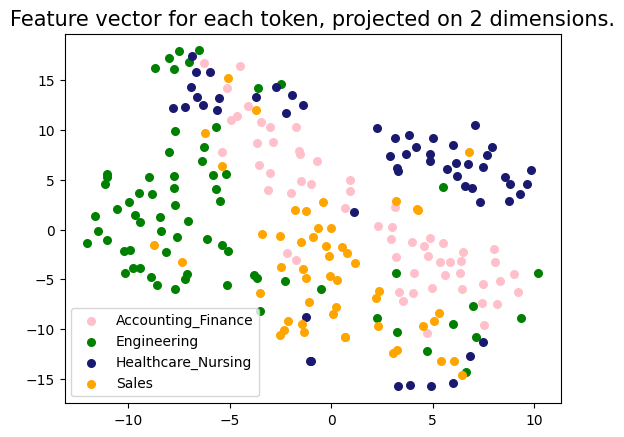

In [58]:
try:
    features = weighted_descp.to_numpy()
except:
    features = weighted_descp
plotTSNE(df['Industry'],features) # plot the tSNE

This plot shows a slight improvement compared to the unweighted one, displaying clearer separations between classes with minimal noise or overlaps. Therefore, it's anticipated that the weighted version of the description will outperform the unweighted one in Task 3. Let's see the result in future.

### Saving outputs
Save the count vector representation as per spectification.
- count_vectors.txt

In [59]:
def count_vector(fileName,vector):
    """
    Function to save count vector into text file
    """
    output_file = open(fileName, 'w') # creates a txt file and open to save sentiments
    string = "\n".join([str(s) for s in vector])
    output_file.write(string)
    output_file.close() # close the file    

In [60]:
count_vector('generated_count_vectors.txt',count_vectors)

## Task 3. Job Advertisement Classification

Here a linear regression is built and validated for following scenarios:
- Using only the description of the job advertisement
- Using only the title of the job advertisement
- Using both the title and description of the job advertisement  


The objective of this task is to compare these scenarios and draw conclusions from the outcomes.

<p style="font-size:12px;">Note: Following 'Luke Gallagher' response to 'Clare Tsang' dated 'Sep 18, 2023' was not used in Task 3 and only term embedding model is used and compared</p>

In [61]:
# creating training and test split
X_train, X_test, y_train, y_test = train_test_split(unweighted_descp, df['Industry'],test_size=0.33, random_state=1)


In [62]:
%%capture 
# %%capture to remove warnings or extend ITERATION LIMI
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=1) # # Initialize logical regression
model.fit(X_train, y_train)

In [63]:
y_pred = model.predict(X_test) # predict

In [64]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7626459143968871

The score is neither the best nor the worst.

In [65]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
conf_mat

array([[42,  1,  0, 14],
       [ 3, 53,  6,  9],
       [ 4,  1, 61,  3],
       [11,  6,  3, 40]], dtype=int64)

From comfussion matrix, we can see that there are some false predictions

Let's visualise the confussion matrix for more clarity

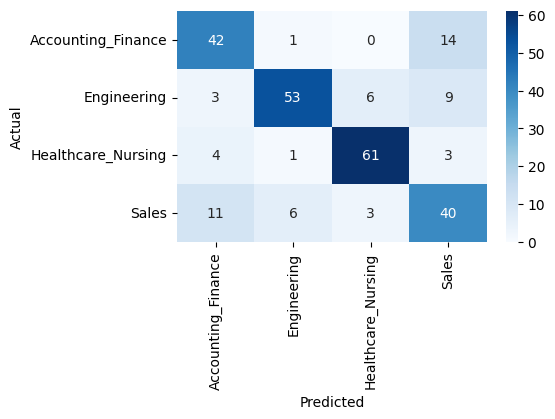

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
labels = df['Industry']
categories = sorted(list(set(labels))) # this gives sorted set of unique label names
plt.figure(figsize=(5, 3))  
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categories, yticklabels=categories,cmap='Blues') # creates a heatmap from the confusion matrix
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It is more clear now.


Creating separate models for each vector representation can be a time-consuming process. Hence,a function called `crossValidation` was developed to perform k-fold cross-validation, allowing us to obtain scores and compare these models. Additionally, F-fold cross-validation provides insights into how well the model will generalize to unseen data.

In [67]:
num_folds = 5
seed = 3
kf = KFold(n_splits= num_folds, random_state=seed, shuffle = True) # initialize a 5 fold validation
print(kf)

KFold(n_splits=5, random_state=3, shuffle=True)


In [68]:
def evaluate(X_train,X_test,y_train, y_test,seed):
    model = LogisticRegression(random_state=seed)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [69]:
%%capture
import pandas as pd
from sklearn.model_selection import KFold

def crossValidation(weighteddata, unweighteddata, labels, num_folds=5, evaluate_function=None, doc_type='descp', seed=3):
    """
    Function perform cross-validation and evaluation of weighted and unweighted language models.

    """
    # Initialize a K-Fold cross-validator
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    fold = 0

    # Empty DataFrame to store evaluation results
    temp = pd.DataFrame(columns=[f'{doc_type}_weighted', f'{doc_type}_unweighted'])
    
    for train_index, test_index in kf.split(list(range(len(labels)))):

        # train test splits of target/label
        y_train = [labels[i] for i in train_index]
        y_test = [labels[i] for i in test_index]

        # train test splits of unweighted and weighted feature data
        X_train_uw, X_test_uw = unweighteddata[train_index], unweighteddata[test_index]
        temp.loc[fold, f'{doc_type}_unweighted'] = evaluate_function(X_train_uw, X_test_uw, y_train, y_test, seed) # previously build evaluate function

        X_train_w, X_test_w = weighteddata[train_index], weighteddata[test_index]
        temp.loc[fold, f'{doc_type}_weighted'] = evaluate_function(X_train_w, X_test_w, y_train, y_test, seed) 
        
        fold += 1
    
    return temp


##### Scenario 1: Using only the description of the job advertisement

In [70]:
%%capture
# 
descp_only = crossValidation(weighted_descp, unweighted_descp, labels, num_folds=5, evaluate_function=evaluate, doc_type='descp')

In [71]:
descp_only.mean()

descp_weighted      0.820885
descp_unweighted    0.804119
dtype: object

In the scenario where only the description of the job advertisement is used, it's clear that the weighted representation performs better. This is evident from both the scores and the 2D t-SNE plot.

##### Scenario 2: Using only the title of the job advertisement

In [72]:
# adding feature

# reading title
with open("generated_features/titles.txt") as f:
    tk_title = [line.strip() for line in f.read().splitlines()]

In [73]:
tk_title = split_token(tk_title)
# tk_title

In [74]:
unweighted_title = docvecs(preTrainedModel,tk_title) # unweighted title

In [75]:
unweighted_title.shape

(776, 100)

Shape is good

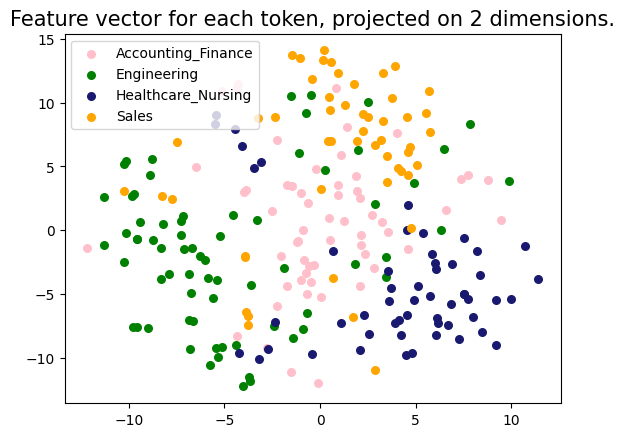

In [76]:
try:
    features = unweighted_title.to_numpy() 
except:
    features = unweighted_title
plotTSNE(df['Industry'],features) # plot the tSNE

It looks more scattered with too much overlapping. 

In [77]:
df['tk_title'] = tk_title
df.head()

,WebIndex,Target,Industry,tk_text,tk_title
0,71185283,0,Accounting_Finance,"[accountant, partqualified, south, east, londo...","[finance, accounts, asst, bromley]"
1,71185283,0,Accounting_Finance,"[hedge, fund, london, recruiting, fund, accoun...","[fund, accountant, hedge, fund]"
2,71185283,2,Healthcare_Nursing,"[exciting, arisen, establish, provider, elderl...","[deputy, home, manager]"
3,71185283,0,Accounting_Finance,"[expanding, recruiting, junior, trainee, broke...","[brokers, wanted, imediate, start]"
4,71185283,2,Healthcare_Nursing,"[rgn, nurse, hospital, fulltime, part, swiis, ...","[rgn, nurses, hospitals, penarth]"


In [78]:
# weighted model for title

tfidf_matrix_title, tfidf_vocabulary_title, weighted_title = gen_WeightedModel(tk_title,preTrainedModel)

In [79]:
validator_v2(tfidf_matrix_title,tfidf_vocabulary_title,7,tk_title)

Article tokens: ['sales', 'purchase', 'ledger', 'clerk', 'maternity', 'cover']
--------------------------------------------

Vector representation:

clerk:0.3878066129863246 cover:0.4842223654341737 ledger:0.4204950194589153 maternity:0.4560225656037708 purchase:0.43601448921024916 sales:0.20063263744100798 

These compact vector representations aid in visually verifying the `gen_WeightedModel` because all words in the `Article tokens` from the previous output have corresponding `Vector representation`, and vice versa.

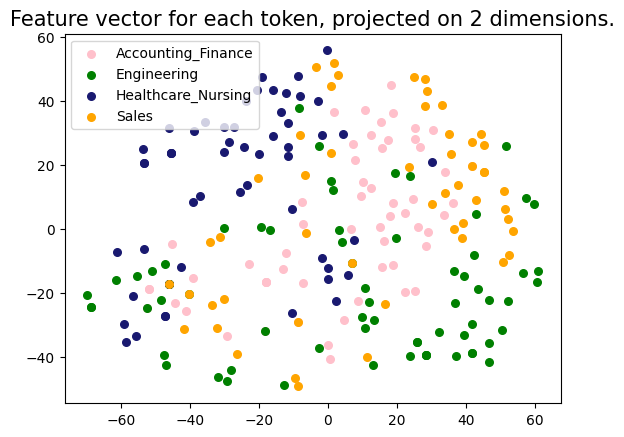

In [80]:
try:
    features = weighted_title.to_numpy() 
except:
    features = weighted_title
plotTSNE(df['Industry'],features)

Even this one is not that great

In [81]:
%%capture
title_only = crossValidation(weighted_title, unweighted_title, labels, num_folds=5, evaluate_function=evaluate, doc_type='title')

In [82]:
title_only.mean()

title_weighted      0.751307
title_unweighted    0.779686
dtype: object

When considering only the title, the unweighted representation yields better results, possibly owing to the smaller size of title vectors. It appears that the unweighted approach is more effective for smaller-sized data.

##### Scenario 3: Using both the title and description of the job advertisement

In this particular scenario, the vector representations of the job descriptions are merged with title vectors.

Alternative approach: Concate document and title feature while feature generation (in Task 1 or earlier in task 2)

To perform a merge, the shapes of both vectors should align. Technically, if all the previous steps are executed correctly, these shapes should be the same.

In [83]:
print("Shape of unweighted title: ",unweighted_title.shape,"\nShape of unweighted description: ",unweighted_descp.shape)

Shape of unweighted title:  (776, 100) 
Shape of unweighted description:  (776, 100)


As expected, they are matching :)

In [84]:
# Merging unweighted vectors together
unweighted_descp_title = np.concatenate([unweighted_descp,unweighted_title], axis=1)

In [85]:
unweighted_descp_title.shape # shape retained

(776, 200)

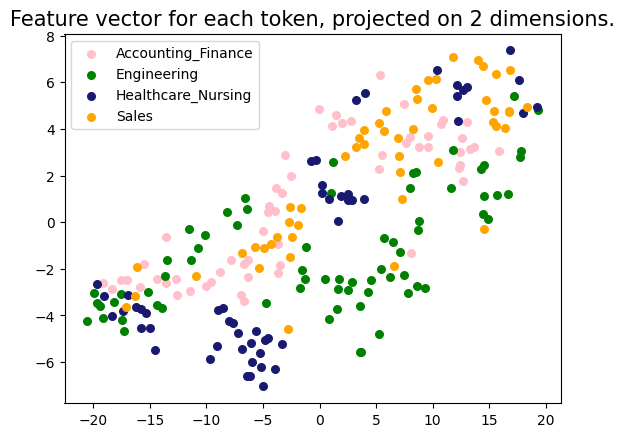

In [86]:
try:
    features = unweighted_descp_title.to_numpy() # convert the document vector dataframe to a numpy array
except:
    # used `docvec` so already is a numpy array
    features = unweighted_descp_title
plotTSNE(df['Industry'],features)

Eventhough there are overlaps, smaller clusters are visible

In [87]:
# merging weighted vectors
weighted_descp_title = np.concatenate([weighted_descp, weighted_title], axis=1)

In [88]:
weighted_descp_title.shape

(776, 200)

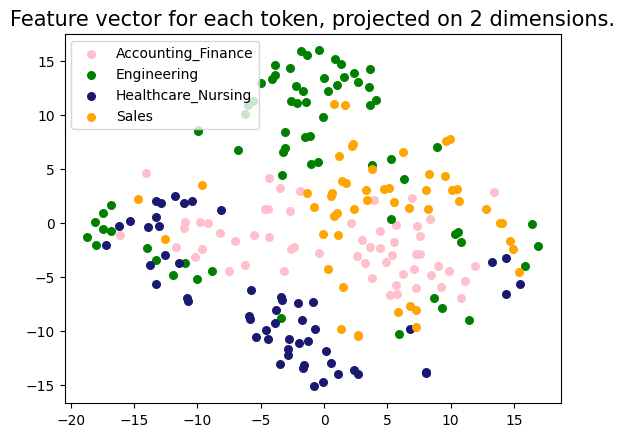

In [89]:
try:
    features = weighted_descp_title.to_numpy()
except:
    features = weighted_descp_title
plotTSNE(df['Industry'],features)

There is some overlaps with better clusters compared to other plots 

In [90]:
%%capture
descp_title = crossValidation(weighted_descp_title, unweighted_descp_title, labels, num_folds=5, evaluate_function=evaluate, doc_type='descp_title')

In [91]:
descp_title.mean()

descp_title_weighted      0.845376
descp_title_unweighted    0.819595
dtype: object

In this context, the weighted vector representation achieved a higher score than the unweighted one, indicating its superior performance.

Let's compare all models

In [92]:
# merging all score data frames together

scores = pd.concat([descp_only, title_only, descp_title], axis=1)

In [93]:
scores

,descp_weighted,descp_unweighted,title_weighted,title_unweighted,descp_title_weighted,descp_title_unweighted
0,0.814103,0.807692,0.737179,0.74359,0.833333,0.814103
1,0.845161,0.83871,0.787097,0.793548,0.870968,0.825806
2,0.845161,0.806452,0.722581,0.780645,0.832258,0.812903
3,0.806452,0.793548,0.729032,0.793548,0.832258,0.819355
4,0.793548,0.774194,0.780645,0.787097,0.858065,0.825806


In [94]:
overall_scores = scores.mean()

In [95]:
overall_scores_df = pd.DataFrame(overall_scores.items(), columns=['Model', 'Score'])
overall_scores_df = overall_scores_df.sort_values(by='Score', ascending=False) # order based on score

In [96]:
overall_scores_df 

,Model,Score
4,descp_title_weighted,0.845376
0,descp_weighted,0.820885
5,descp_title_unweighted,0.819595
1,descp_unweighted,0.804119
3,title_unweighted,0.779686
2,title_weighted,0.751307


In [97]:
winner = scores.mean().idxmax()
print("Best performing model is: ",winner)

Best performing model is:  descp_title_weighted


### Saving Model for web application)

In [98]:
# Doc vector save

preTrainedModel.save('generated_model/glove.model')

# can test 

# from gensim.models import KeyedVectors
# g_model = KeyedVectors.load("glove.model")

# docvecs(g_model, [['hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', 'hospital', 'nurse', 'care', '']])

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(weighted_descp, df['Industry'],test_size=0.33, random_state=1)
model = LogisticRegression(random_state=1) # # Initialize logical regression
model.fit(X_train, y_train)
y_pred = model.predict(X_test) # predict
accuracy_score(y_test, y_pred)

C:\Users\skish\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8054474708171206

In [100]:
import joblib
joblib.dump(model, 'generated_model/logistic_regression_model.pkl')

['logistic_regression_model.pkl']

## Summary

This document explores job advertisement text analysis, where Task 2 involves creating varied feature representations for job descriptions, including Count vectors and TF-IDF weighted vectors. Task 3 focuses on categorizing job advertisements using logistic regression and assesses language model and feature representation performance. Additionally, it investigates the impact of including extra information like job titles. The document aims to uncover optimal strategies for job advertisement categorization and emphasizes the importance of feature selection in text analysis. Notably, the results indicate that adding extra information has proven to be effective in enhancing model accuracy.


<p style="font-size:12px;">Note: The performance results presented here are specific to the given dataset and the generated models. Different models may perform differently when additional features or different datasets are considered. It's essential to assess model performance carefully in various contexts and datasets to make informed decisions</p>

As the `descp_title_weighted` has clear advantage and both `descp_weighted` and `descp_title_unweighted` are almost comparble. So for the models in this project adding extra information has proven to be effective in enhancing model accuracy

## Acknowledgements

Some of the code (functions) are used (with modification) from weekly (week 7 to week 9) activity notebooks and lab notebooks

## References
[1]The Coding Train, “12.2: Color Vectors - Programming with Text,” www.youtube.com, Oct. 21, 2018. https://www.youtube.com/watch?v=mI23bDF0VRI (accessed Sep. 30, 2023).

[2]aparrish, “Understanding Word Vectors,” GitHub Gist. https://gist.github.com/aparrish/2f562e3737544cf29aaf1af30362f469 (accessed Sep. 30, 2023).

[3] Week7, Week8, Week9 codes and ideas from both activity and lab materials